# AdaFace LFW Evaluation

Dưới đây, chúng ta sẽ đánh giá mô hình nhận diện khuôn mặt AdaFace trên dataset LFW (Labeled Faces in the Wild).

## Mục tiêu:
- So sánh các cặp ảnh khuôn mặt (cùng người / khác người)
- Tính độ tương đồng giữa các feature vector
- Đánh giá độ chính xác của mô hình

## Bước 1: Import thư viện cần thiết

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

from face_alignment import align  # Căn chỉnh khuôn mặt
from inference import load_pretrained_model, to_input  # Load model & xử lý ảnh

## Bước 2: Cấu hình đường dẫn

- `model_name`: Tên kiến trúc model (ir_50 = ResNet-50)
- `lfw_dir`: Thư mục chứa ảnh LFW
- `match_pairs_file`: File CSV chứa cặp ảnh **cùng người**
- `mismatch_pairs_file`: File CSV chứa cặp ảnh **khác người**

In [2]:
model_name = 'ir_50'
lfw_dir = '../datasets/lfw-deepfunneled/lfw-deepfunneled'
match_pairs_file = '../datasets/matchpairsDevTest.csv'
mismatch_pairs_file = '../datasets/mismatchpairsDevTest.csv'
roc_output = 'lfw_roc_curve.png'
dist_output = 'lfw_similarity_distribution.png'
results_output = 'lfw_results.txt'

## Bước 3: Định nghĩa các hàm tiện ích

### 3.1 `get_lfw_image_path`: Tạo đường dẫn đến ảnh
- Format: `PersonName/PersonName_0001.jpg`
- VD: `Albert_Einstein/Albert_Einstein_0001.jpg`

In [3]:
def get_lfw_image_path(lfw_dir: str, name: str, imagenum: int) -> str:
    """Tạo đường dẫn đầy đủ đến ảnh LFW"""
    image_name = f"{name}_{imagenum:04d}.jpg"  # Format số thành 0001, 0002,...
    return os.path.join(lfw_dir, name, image_name)

# Test
print("Ví dụ đường dẫn:", get_lfw_image_path(lfw_dir, "Albert_Einstein", 1))

Ví dụ đường dẫn: ../datasets/lfw-deepfunneled/lfw-deepfunneled\Albert_Einstein\Albert_Einstein_0001.jpg


### 3.2 `extract_feature`: Trích xuất feature vector từ ảnh

**Các bước:**
1. Kiểm tra file tồn tại
2. Căn chỉnh khuôn mặt (face alignment) - chuẩn hóa góc nghiêng, tỉ lệ
3. Chuyển ảnh RGB → BGR tensor (định dạng model)
4. Đưa qua model AdaFace → ra feature vector (embedding)
5. Feature vector có shape (512,) - đại diện cho khuôn mặt

In [4]:
def extract_feature(model, image_path: str):
    """Trích xuất feature vector (embedding) từ ảnh khuôn mặt"""
    if not os.path.exists(image_path):
        return None
    
    try:
        # Bước 1: Căn chỉnh khuôn mặt (detect face + crop + align)
        aligned_rgb_img = align.get_aligned_face(image_path)
        if aligned_rgb_img is None:
            return None
        
        # Bước 2: Chuyển thành tensor đầu vào cho model
        bgr_tensor_input = to_input(aligned_rgb_img)
        
        # Bước 3: Trích xuất feature qua model (không tính gradient)
        with torch.no_grad():
            feature, _ = model(bgr_tensor_input)
        
        # Bước 4: Chuyển tensor → numpy array
        return feature.squeeze().numpy()
    
    except Exception as exc:
        print(f"Error processing {image_path}: {exc}")
        return None

### 3.3 `compute_similarity`: Tính độ tương đồng giữa 2 feature

**Công thức: Cosine Similarity**
```
similarity = (feature1 · feature2) / (||feature1|| × ||feature2||)
```

- Kết quả từ -1 đến 1
- Càng gần 1 = càng giống nhau
- Càng gần 0 = khác nhau

In [5]:
def compute_similarity(feature1, feature2):
    """Tính cosine similarity giữa 2 feature vector"""
    if feature1 is None or feature2 is None:
        return None
    
    # Chuẩn hóa vector về độ dài = 1 (unit vector)
    feature1 = feature1 / np.linalg.norm(feature1)
    feature2 = feature2 / np.linalg.norm(feature2)
    
    # Tính tích vô hướng (dot product) = cosine similarity
    return np.dot(feature1, feature2)

## Bước 4: Hàm đánh giá các cặp ảnh

### Cấu trúc file CSV:
- **Match pairs** (cùng người): `name, imagenum1, imagenum2`
  - VD: `Albert_Einstein, 1, 2` → so sánh ảnh 1 và 2 của Einstein
  
- **Mismatch pairs** (khác người): `name, imagenum1, name, imagenum2`
  - VD: `Albert_Einstein, 1, Bill_Gates, 1` → so sánh Einstein và Bill Gates

### Có try-catch để bắt lỗi index out of range:

In [6]:
def evaluate_lfw_pairs(model, lfw_dir: str, pairs_file: str, is_match: bool = True):
    """Đánh giá các cặp ảnh từ file CSV"""
    df = pd.read_csv(pairs_file)
    similarities, labels = [], []
    label = 1 if is_match else 0  # 1 = cùng người, 0 = khác người
    
    print(f"\n{'='*60}")
    print(f"Đang xử lý: {os.path.basename(pairs_file)}")
    print(f"Tổng số cặp: {len(df)}")
    print(f"{'='*60}\n")
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc='Processing'):
        try:
            if is_match:
                # Cặp cùng người: lấy theo tên cột
                name = row['name']
                imagenum1 = int(row['imagenum1'])
                imagenum2 = int(row['imagenum2'])
                path1 = get_lfw_image_path(lfw_dir, name, imagenum1)
                path2 = get_lfw_image_path(lfw_dir, name, imagenum2)
            else:
                # Cặp khác người: lấy theo index (vì có 2 cột 'name' trùng tên)
                name1 = row.iloc[0]
                imagenum1 = int(row.iloc[1])
                name2 = row.iloc[2]
                imagenum2 = int(row.iloc[3])
                path1 = get_lfw_image_path(lfw_dir, name1, imagenum1)
                path2 = get_lfw_image_path(lfw_dir, name2, imagenum2)
        
        except IndexError as e:
            # BẮT LỖI INDEX OUT OF RANGE
            print(f"\n⚠️ LỖI tại dòng {idx + 1}:")
            print(f"   Số cột trong row: {len(row)}")
            print(f"   Nội dung row: {row.values}")
            print(f"   Chi tiết lỗi: {e}")
            print(f"{'='*60}\n")
            continue  # Bỏ qua cặp này, tiếp tục cặp tiếp theo
        
        # Trích xuất feature cho 2 ảnh
        feature1 = extract_feature(model, path1)
        feature2 = extract_feature(model, path2)
        
        # Tính độ tương đồng
        similarity = compute_similarity(feature1, feature2)
        
        if similarity is not None:
            similarities.append(similarity)
            labels.append(label)
    
    print(f"\n✓ Hoàn thành: {len(similarities)} cặp hợp lệ\n")
    return similarities, labels

## Bước 5: Tính các chỉ số đánh giá

### Các chỉ số quan trọng:
- **Accuracy**: Tỉ lệ dự đoán đúng
- **Precision**: Trong các cặp dự đoán "cùng người", bao nhiêu % đúng?
- **Recall**: Trong các cặp thực sự "cùng người", bắt được bao nhiêu %?
- **F1-Score**: Trung bình điều hòa của Precision và Recall
- **ROC AUC**: Diện tích dưới đường cong ROC (càng gần 1 càng tốt)

### Tìm threshold tối ưu:
- Threshold là ngưỡng quyết định: similarity > threshold → cùng người
- Tìm threshold cho accuracy cao nhất

In [7]:
def compute_metrics(similarities, labels, thresholds=None):
    """Tính các chỉ số đánh giá mô hình"""
    similarities = np.array(similarities)
    labels = np.array(labels)
    
    # Tạo danh sách threshold để thử (từ 0.0 đến 1.0)
    if thresholds is None:
        thresholds = np.arange(0.0, 1.0, 0.01)
    
    # TÌM THRESHOLD TỐI ƯU
    best_acc, best_threshold = 0, 0
    for threshold in thresholds:
        predictions = (similarities > threshold).astype(int)
        accuracy = np.mean(predictions == labels)
        if accuracy > best_acc:
            best_acc = accuracy
            best_threshold = threshold
    
    # Dự đoán với threshold tốt nhất
    predictions = (similarities > best_threshold).astype(int)
    
    # TÍNH CONFUSION MATRIX
    tp = np.sum((predictions == 1) & (labels == 1))  # True Positive
    tn = np.sum((predictions == 0) & (labels == 0))  # True Negative
    fp = np.sum((predictions == 1) & (labels == 0))  # False Positive
    fn = np.sum((predictions == 0) & (labels == 1))  # False Negative
    
    # TÍNH CÁC CHỈ SỐ
    accuracy = (tp + tn) / len(labels)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # TÍNH ROC CURVE
    fpr, tpr, _ = roc_curve(labels, similarities)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy,
        'best_threshold': best_threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

## Bước 6: Vẽ biểu đồ

### 6.1 ROC Curve (Receiver Operating Characteristic)
- Trục X: False Positive Rate (tỉ lệ nhận nhầm)
- Trục Y: True Positive Rate (tỉ lệ nhận đúng)
- Đường chéo: random guess
- Model càng tốt → đường cong càng gần góc trên bên trái

### 6.2 Similarity Distribution
- Phân bố điểm similarity của cặp cùng người (xanh lá)
- Phân bố điểm similarity của cặp khác người (đỏ)
- 2 phân bố càng tách biệt → model càng tốt

In [8]:
def plot_roc_curve(fpr, tpr, roc_auc, output_path='lfw_roc_curve.png'):
    """Vẽ đường cong ROC"""
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - AdaFace on LFW')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: {output_path}")
    plt.show()


def plot_distribution(match_sims, mismatch_sims, output_path='lfw_similarity_distribution.png'):
    """Vẽ phân bố điểm similarity"""
    plt.figure(figsize=(12, 6))
    plt.hist(match_sims, bins=50, alpha=0.5, 
             label='Same Person (Positive)', color='green')
    plt.hist(mismatch_sims, bins=50, alpha=0.5, 
             label='Different Person (Negative)', color='red')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Similarity Score Distribution - AdaFace on LFW')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: {output_path}")
    plt.show()

## Bước 7: CHẠY ĐÁNH GIÁ

### Quy trình:
1. Load model AdaFace đã train
2. Đánh giá cặp match (cùng người)
3. Đánh giá cặp mismatch (khác người)
4. Gộp kết quả và tính metrics
5. Vẽ biểu đồ
6. Lưu kết quả ra file

ADAFACE EVALUATION ON LFW DATASET

Đang load AdaFace model...
✓ Model loaded successfully!


Đang xử lý: matchpairsDevTest.csv
Tổng số cặp: 500



Processing:  12%|█▏        | 61/500 [00:17<01:34,  4.65it/s]

Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range


Processing:  23%|██▎       | 113/500 [00:31<01:26,  4.46it/s]

Face detection Failed due to error.
list index out of range


Processing: 100%|██████████| 500/500 [02:24<00:00,  3.45it/s]



✓ Hoàn thành: 497 cặp hợp lệ


Đang xử lý: mismatchpairsDevTest.csv
Tổng số cặp: 500



Processing:  21%|██▏       | 107/500 [00:36<03:26,  1.91it/s]

Face detection Failed due to error.
list index out of range


Processing: 100%|██████████| 500/500 [03:21<00:00,  2.48it/s]



✓ Hoàn thành: 499 cặp hợp lệ


Đang tính các chỉ số đánh giá...

📊 KẾT QUẢ ĐÁNH GIÁ

Tổng số cặp: 996
  - Match pairs (cùng người): 497
  - Mismatch pairs (khác người): 499
--------------------------------------------------------------------------------
Accuracy:        97.29%
Best Threshold:  0.2800
Precision:       100.00%
Recall:          94.57%
F1-Score:        97.21%
ROC AUC:         0.9790
--------------------------------------------------------------------------------
True Positives:  470
True Negatives:  499
False Positives: 0
False Negatives: 27

Đang vẽ biểu đồ...
✓ Đã lưu: lfw_roc_curve.png


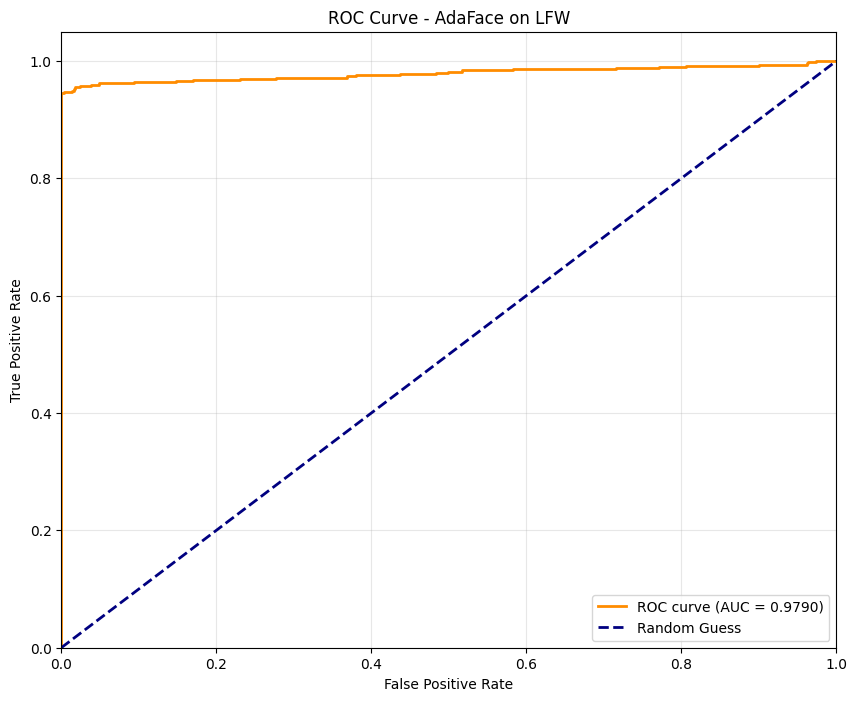

✓ Đã lưu: lfw_similarity_distribution.png


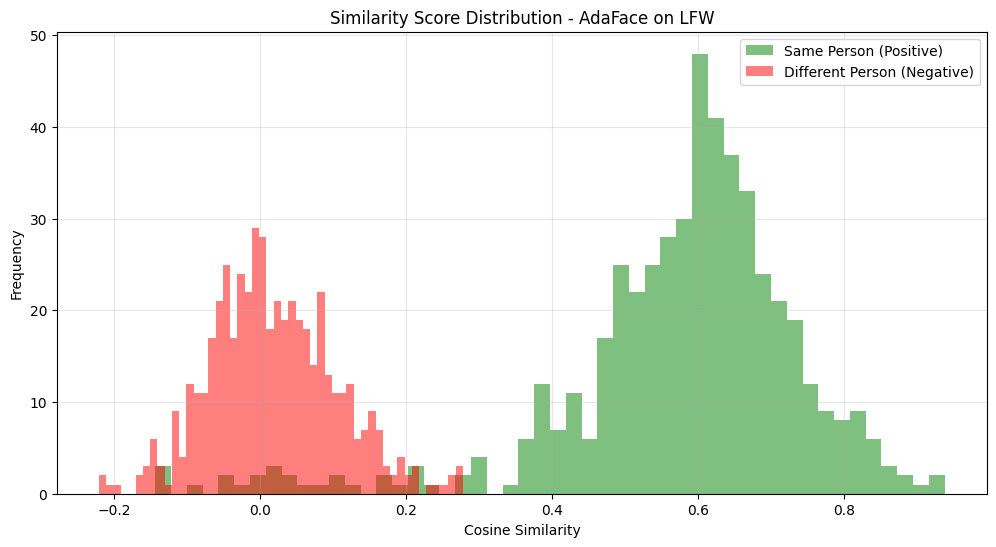


Đang lưu kết quả...
✓ Đã lưu: lfw_results.txt

✅ HOÀN THÀNH ĐÁNH GIÁ!


In [9]:
print('=' * 80)
print('ADAFACE EVALUATION ON LFW DATASET')
print('=' * 80)

# BƯỚC 1: LOAD MODEL
print('\nĐang load AdaFace model...')
model = load_pretrained_model(model_name)
print('✓ Model loaded successfully!\n')

# BƯỚC 2: ĐÁNH GIÁ MATCH PAIRS (cùng người)
match_sims, match_labels = evaluate_lfw_pairs(
    model, lfw_dir, match_pairs_file, is_match=True
)

# BƯỚC 3: ĐÁNH GIÁ MISMATCH PAIRS (khác người)
mismatch_sims, mismatch_labels = evaluate_lfw_pairs(
    model, lfw_dir, mismatch_pairs_file, is_match=False
)

# BƯỚC 4: GỘP KẾT QUẢ
all_similarities = match_sims + mismatch_sims
all_labels = match_labels + mismatch_labels

# BƯỚC 5: TÍNH METRICS
print('\nĐang tính các chỉ số đánh giá...')
metrics = compute_metrics(all_similarities, all_labels)

# BƯỚC 6: IN KẾT QUẢ
print('\n' + '=' * 80)
print('📊 KẾT QUẢ ĐÁNH GIÁ')
print('=' * 80)
print(f"\nTổng số cặp: {len(all_similarities):,}")
print(f"  - Match pairs (cùng người): {len(match_sims):,}")
print(f"  - Mismatch pairs (khác người): {len(mismatch_sims):,}")
print('-' * 80)
print(f"Accuracy:        {metrics['accuracy']:.2%}")
print(f"Best Threshold:  {metrics['best_threshold']:.4f}")
print(f"Precision:       {metrics['precision']:.2%}")
print(f"Recall:          {metrics['recall']:.2%}")
print(f"F1-Score:        {metrics['f1_score']:.2%}")
print(f"ROC AUC:         {metrics['roc_auc']:.4f}")
print('-' * 80)
print(f"True Positives:  {metrics['tp']:,}")
print(f"True Negatives:  {metrics['tn']:,}")
print(f"False Positives: {metrics['fp']:,}")
print(f"False Negatives: {metrics['fn']:,}")
print('=' * 80)

# BƯỚC 7: VẼ BIỂU ĐỒ
print('\nĐang vẽ biểu đồ...')
plot_roc_curve(metrics['fpr'], metrics['tpr'], metrics['roc_auc'], 
               output_path=roc_output)
plot_distribution(match_sims, mismatch_sims, output_path=dist_output)

# BƯỚC 8: LƯU KẾT QUẢ
print('\nĐang lưu kết quả...')
with open(results_output, 'w', encoding='utf-8') as f:
    f.write("ADAFACE EVALUATION ON LFW DATASET\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Total Pairs: {len(all_similarities)}\n")
    f.write(f"Match Pairs: {len(match_sims)}\n")
    f.write(f"Mismatch Pairs: {len(mismatch_sims)}\n\n")
    f.write(f"Accuracy: {metrics['accuracy']:.4f}\n")
    f.write(f"Best Threshold: {metrics['best_threshold']:.4f}\n")
    f.write(f"Precision: {metrics['precision']:.4f}\n")
    f.write(f"Recall: {metrics['recall']:.4f}\n")
    f.write(f"F1-Score: {metrics['f1_score']:.4f}\n")
    f.write(f"ROC AUC: {metrics['roc_auc']:.4f}\n\n")
    f.write(f"True Positives: {metrics['tp']}\n")
    f.write(f"True Negatives: {metrics['tn']}\n")
    f.write(f"False Positives: {metrics['fp']}\n")
    f.write(f"False Negatives: {metrics['fn']}\n")

print(f"✓ Đã lưu: {results_output}")
print('\n' + '=' * 80)
print('✅ HOÀN THÀNH ĐÁNH GIÁ!')
print('=' * 80)

## Tổng kết

### Code này làm gì?
1. **Load model** AdaFace đã được train trên dataset CASIA-WebFace
2. **Trích xuất feature** từ các ảnh khuôn mặt (embedding 512 chiều)
3. **Tính similarity** giữa các cặp ảnh bằng cosine similarity
4. **Đánh giá** accuracy, precision, recall, F1, ROC AUC
5. **Vẽ biểu đồ** ROC curve và phân bố similarity

### Ý nghĩa kết quả:
- **Accuracy cao** → Model phân biệt tốt cùng người / khác người
- **ROC AUC gần 1** → Model rất tốt
- **Threshold tối ưu** → Dùng để quyết định trong thực tế

### Ứng dụng:
- Hệ thống chấm công nhận diện khuôn mặt
- Unlock điện thoại bằng khuôn mặt
- Tìm kiếm khuôn mặt trong database
- Xác thực danh tính